In [2]:
import pandas as pd
import numpy as np
import re
import spacy

### Clean and get subsets

In [26]:
def clean_df(df, filter_state=False, state="CLOSED", merged=False):
    """Removes duplicates, cleans text, optionally filters by state, and merges conversations."""
    df = df.drop_duplicates(subset=['Prompt'], keep='first')
    
    # replace newlines with empty space and strip
    df.loc[:, 'difference'] = df['difference'].str.replace(r'\n+', ' ', regex=True).str.strip()

    # drop rows where 'difference' is an empty string (indicates prompt was just code)
    df = df[df['difference'].notna() & (df['difference'] != '')]

    # remove URLs and file paths
    df.loc[:, 'difference'] = df['difference'].apply(lambda text: re.sub(r'http\S+|www\S+|https\S+', '', text))
    df.loc[:, 'difference'] = df['difference'].apply(lambda text: re.sub(r'[a-zA-Z]:\\[\\\S|*\S]?.*|/\S+', '', text))

    if filter_state:
        df = df[df['State'] == state].reset_index(drop=True)

    if merged:
        df = df.groupby('conversation_id').agg({
            'difference': lambda x: ' '.join(x.dropna().astype(str)) if not x.dropna().empty else None,  # avoid empty groups
            'State': 'first',       # keep first value of State (same for all prompts in a conversation)
            'numPrompts': 'first',  # keep first value of numPrompts
        }).reset_index()

    return df

In [5]:
# load data
df = pd.read_csv('NL_code_difference_clean.csv', na_values=['', 'nan'])

# get different subsets
df_full = clean_df(df)
df_open = clean_df(df, True, "OPEN") # OPEN issue prmopts
df_closed = clean_df(df, True) # CLOSED issue prompts

### Tokenization functions

In [6]:
# load SpaCy model
nlp = spacy.load('en_core_web_sm')

words_to_remove = ['what', 'how', 'why', 'when', 'where', 'which', 'if', 'can', 'could', 'would', 'should', 'must',
                   'explain', 'show', 'tell', 'help', 'write', 'make', 'create', 'see', 'are', 'was', 'were', 
                   'using', 'this', 'that', 'mean', 'means', 'need', 'want', 'have', 'give', 'get', 'please', 
                   'no', 'not', 'only', 'many', 'all']

# remove relevant words from stopwords
for word in words_to_remove:
    if word in nlp.Defaults.stop_words: 
        nlp.Defaults.stop_words.remove(word)
        nlp.vocab[word].is_stop = False

# add words to stopwords
words_to_add = ['i', 'you', 'be', 'this', 'that', 'it', 'in', 'for', 'do', 'does', 'did']
for word in words_to_add:
    nlp.vocab[word].is_stop = True

def custom_tokenizer(text):
    """Tokenizes text using SpaCy, removing code-related terms and filtering by POS tags."""
    code_terms = {
        'github', 'com', 'http', 'https', 'localhost', 'api',
        'json', 'xml', 'html', 'css', 'js', 'php', 'sql',
        'readme', 'md', 'txt', 'pdf', 'doc', 'docx'
    }

    # process the text with SpaCy (convert to lowercase before processing)
    doc = nlp(text.lower())
    
    # define allowed POS tags
    allowed_pos = {"ADJ", "NOUN", "VERB", "AUX", "PRON", "ADV", 
                   "DET", "SCONJ", "INTJ", "ADP", "PART"}

    # filter tokens once and extract both lemmas and POS tags
    filtered_tokens = [(token.lemma_, token.pos_) for token in doc 
                       if token.is_alpha
                       and not token.is_space
                       and not token.is_punct
                       and not token.is_stop
                       and token.text not in code_terms
                       and token.pos_ in allowed_pos]

    # extract lemmas and POS tags separately
    tokens = [lemma for lemma, _ in filtered_tokens]
    pos_tags = [pos for _, pos in filtered_tokens]
    
    return tokens, pos_tags

def count_pos(tags):
    """Extract counts of position tags as features."""
    pos_features = dict.fromkeys(["NOUN", "VERB", "AUX", "PRON", "DET", "ADV", "SCONJ"], 0)
    
    for tag in tags:
        if tag in pos_features:
            pos_features[tag] += 1
    
    return list(pos_features.values())

def get_tokenized(df):
    """Tokenizes the 'difference' column, returning raw tokens, tokenized text, and POS tag counts."""  
    raw_tokens = []
    tokenized_data = []
    pos_data = []
    
    for text in df['difference']:
        tokens, pos_tags = custom_tokenizer(text)
        raw_tokens.append(tokens)
        tokenized_data.append(" ".join(tokens))
        pos_data.append(count_pos(pos_tags))

    return raw_tokens, tokenized_data, pos_data

In [7]:
# get raw tokens, tokenized strings, and counts of position tags for each observation in dataframe
raw_tokens, tokenized_data, pos_data = get_tokenized(df_closed)

# add to df
df_closed['raw_tokens'] = raw_tokens

### Get embeddings

In [8]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

def get_embeddings(tokenized_data):
    """Generates embeddings for tokenized text using a pre-trained model."""  
    embeddings = []
    for tokens in tokenized_data:
        inputs = tokenizer(" ".join(tokens), return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[0][0].numpy()
        embeddings.append(cls_embedding)
    
    embeddings = np.array(embeddings)
    
    return embeddings

In [9]:
embeddings = get_embeddings(tokenized_data)

### TF-IDF

In [10]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_vectorize(tokenized_data, ngram_range=(1,2), max_features=100, min_df=0.01, max_df=0.7):
    """Transforms tokenized text into TF-IDF features with configurable n-grams and filtering."""  
    vectorizer = TfidfVectorizer(
        ngram_range=ngram_range,  # enable different sized ngrams as features
        max_features=max_features,    
        min_df=min_df,  # remove terms that appear in less than 1% of documents
        max_df=max_df,  # remove terms that appear in more than 70% of documents
        stop_words=list(nlp.Defaults.stop_words) # Default stopwords
    )

    # transform the tokenized text data into TF-IDF features
    tf_idf = vectorizer.fit_transform(tokenized_data)
    return tf_idf, vectorizer

In [11]:
# get tf-idf scores and vectorizer
tf_idf, vectorizer = tfidf_vectorize(tokenized_data, (1, 3), 1000, 0.02) # remove terms that appear in less than 2% of documents
print(tf_idf.shape[1]) # check number of features

139


/Users/janeshen/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


### k-Means clustering

In [12]:
import random
from sklearn.cluster import KMeans

def get_kmeans(df, features, k=5, show_samples=False, sample_size=10):
    """Clusters data using K-Means and optionally displays sample texts from each cluster."""  
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    
    df['cluster'] = kmeans.predict(features)
    print(df['cluster'].value_counts())

    if show_samples:
        for i in range(k):
            print(f"Cluster {i}:")
            
            # get indices where cluster == i
            cluster_indices = df[df['cluster'] == i].index.tolist()
            
            # sample min(sample_size, available indices) to avoid errors
            sampled_indices = random.sample(cluster_indices, min(sample_size, len(cluster_indices)))

            # print tokenized data for the sampled indices
            for idx in sampled_indices:
                # print(f"  - {tokenized_data[idx]}")
                print(f"  - {df['difference'].iloc[idx]}")
            
            print('=' * 50)
            print('\n')

    return kmeans # return fit model

def get_top_words(tfidf_vectorizer, kmeans, n_words):
    """Retrieves and prints the top TF-IDF words for each K-Means cluster."""  
    feature_names = tfidf_vectorizer.get_feature_names_out()
    cluster_centers = kmeans.cluster_centers_
    
    # store top words for each cluster
    top_words_per_cluster = {}
    n_top_words = n_words
    
    # loop over each cluster center
    for i in range(kmeans.n_clusters):
        # get the center vector for the current cluster
        center_vector = cluster_centers[i]
        
        # get the indices of the top words based on the highest TF-IDF values
        top_indices = center_vector.argsort()[-n_top_words:][::-1]
        
        # map the top indices to the corresponding feature names (words)
        top_words = [feature_names[idx] for idx in top_indices]
        
        # store top words for the current cluster
        top_words_per_cluster[i] = top_words
    
    # print top words for each cluster
    for i, words in top_words_per_cluster.items():
        print(f"Cluster {i}: {', '.join(words)}")

In [13]:
# cluster using embeddings... not good
# kmeans = get_kmeans(df_closed, embeddings, k=7 ,show_samples=True) 

# cluster using tf-idf features
kmeans = get_kmeans(df_closed, tf_idf, 5, show_samples=False)

cluster
0    139
4     62
1     59
2     55
3     31
Name: count, dtype: int64


In [14]:
# show top words per cluster
get_top_words(vectorizer, kmeans, 20)

Cluster 0: code, can, run, text, return, error, please, list, like, need, ok, try, image, create, no, get, example, response, find, help
Cluster 1: how, use, can, how can, show, get, could, create, number, implement, service, base, when, file, make, content, instead, code, second, not
Cluster 2: want, file, give, use, option, authentication, post, step, all, issue, like, open, can, if, how, what, have, database, time, function
Cluster 3: what, have, like, type, kind, option, use, please, error, database, datum, mean, possible, new, server, could, would, response, why, change
Cluster 4: would, have, not, work, if, which, user, think, could, use, write, why, request, need, model, environment, should, variable, verification, possible


### Get normalized counts of position tags and target words

In [15]:
from sklearn.preprocessing import MinMaxScaler

def transform_word_count(df, target_words):
    """Counts and normalizes occurrences of target words in tokenized text.""" 
    for word in target_words:
        df[word] = df['raw_tokens'].apply(lambda tokens: tokens.count(word))

    # normalize the word counts for each cluster
    scaler = MinMaxScaler()

    # normalize each target word's count across the entire dataset
    for word in target_words:
        word_counts = df[word].values.reshape(-1, 1)
        normalized_word_counts = scaler.fit_transform(word_counts).flatten()

        # ensure the target column is of type float before assigning the normalized values
        df[word] = df[word].astype(float)

        # assign the normalized values back to the dataframe
        df[word] = normalized_word_counts

    return df

def transform_pos(pos_data, feature_names):
    """Normalizes POS tag counts and returns a DataFrame with the transformed features."""  
    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(np.array(pos_data))
    
    pos_df = pd.DataFrame(normalized_features, columns=feature_names)

    return pos_df

In [20]:
feature_names = ["NOUN", "VERB", "AUX", "PRON", "DET", "ADV", "SCONJ"] # INTJ", "PART", "ADJ", "ADP"
target_words = ["why", "what", "which", "if", "how", "can", "would", "could", "want", "code", "use"]

# get dataframe of normalized count of position tags
pos_df = transform_pos(pos_data, feature_names)

# get normalized count of target words
df_closed = transform_word_count(df_closed, target_words)

# combine with original dataframe
df_combined = pd.concat([df_closed, pos_df], axis=1)

### Visualization

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_features_and_targets(df, feature_names, target_words, word_to_pos):
    """
    Generates side-by-side plots of mean counts for position tag features and target words across clusters,
    with target word colors matching their POS tags.
    """
    # sort target words by their POS tags
    sorted_target_words = sorted(target_words, key=lambda word: feature_names.index(word_to_pos.get(word, 'UNKNOWN')))
    
    # create color mapping for POS tags
    pos_colors = dict(zip(feature_names, sns.color_palette("tab10", len(feature_names))))
    
    # create word colors based on their POS tags
    word_colors = {word: pos_colors.get(word_to_pos.get(word, 'UNKNOWN'), 'gray') for word in sorted_target_words}
    
    df_grouped = df.groupby('cluster')[feature_names + sorted_target_words].mean().reset_index()
    
    for cluster_id in df_grouped['cluster']:
        df_cluster = df_grouped[df_grouped['cluster'] == cluster_id].melt(
            id_vars='cluster', 
            var_name='Feature', 
            value_name='Mean Value'
        )
        
        fig, axes = plt.subplots(1, 2, figsize=(6, 3.5), sharey=True)
        
        # plot position tag features
        pos_plot = sns.barplot(
            data=df_cluster[df_cluster['Feature'].isin(feature_names)],
            x='Feature', 
            y='Mean Value',
            hue='Feature',  
            palette=pos_colors,
            legend=False,   
            ax=axes[0]
        )
        
        # plot target words with colors matching their POS tags
        word_plot = sns.barplot(
            data=df_cluster[df_cluster['Feature'].isin(sorted_target_words)],
            x='Feature', 
            y='Mean Value',
            ax=axes[1]
        )
        
        # manually set colors for word bars
        for i, bar in enumerate(word_plot.patches):
            word = sorted_target_words[i]
            bar.set_color(word_colors[word])
        
        # customize plots
        for ax in axes:
            ax.tick_params(axis='x', rotation=45)
            ax.set_ylim(0, 0.6)
            ax.grid(True, linestyle='-', linewidth=0.7, color='lightgray')
            for bar in ax.patches:
                bar.set_zorder(10)
        
        # set labels
        axes[0].set_xlabel("Position Tag")
        axes[0].set_ylabel("Mean Count")
        axes[1].set_xlabel("Target Word")
        axes[1].set_ylabel("")

        plt.tight_layout()
        plt.show()

def plot_overall_features_and_targets(df, feature_names, target_words, word_to_pos):
    """Generates side-by-side plots of mean counts for position tag features and target words across the entire dataset."""
    # sort target words by their POS tags
    sorted_target_words = sorted(target_words, key=lambda word: feature_names.index(word_to_pos.get(word, 'UNKNOWN')))
    
    # create color mapping for POS tags
    pos_colors = dict(zip(feature_names, sns.color_palette("tab10", len(feature_names))))
    
    # create word colors based on their POS tags using the mapping
    word_colors = {word: pos_colors.get(word_to_pos.get(word, 'UNKNOWN'), 'gray') 
                   for word in sorted_target_words}
    
    # calculate means for features and target words
    feature_means = df[feature_names].mean().reset_index()
    feature_means.columns = ['Feature', 'Mean']
    
    target_means = df[sorted_target_words].mean().reset_index()
    target_means.columns = ['Feature', 'Mean']
    
    # create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(6, 3.5), sharey=True)
    
    # plot position tag features
    sns.barplot(
        data=feature_means,
        x="Feature",
        y="Mean",
        hue="Feature",
        palette=pos_colors,
        legend=False,
        ax=axes[0]
    )
    
    # plot target words
    word_plot = sns.barplot(
        data=target_means,
        x="Feature",
        y="Mean",
        ax=axes[1]
    )
    
    # manually set colors for word bars
    for i, bar in enumerate(word_plot.patches):
        word = sorted_target_words[i]
        bar.set_color(word_colors[word])
    
    # customize both plots
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylim(0, 0.12)
        ax.grid(True, linestyle='-', linewidth=0.7, color='lightgray')
        for bar in ax.patches:
            bar.set_zorder(10)
    
    # set labels
    axes[0].set_xlabel("Position Tag")
    axes[0].set_ylabel("Mean Count")
    axes[1].set_xlabel("Target Word")
    axes[1].set_ylabel("")
    
    plt.tight_layout()
    plt.show()

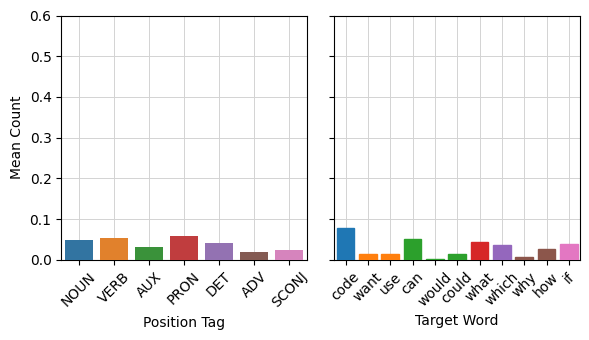

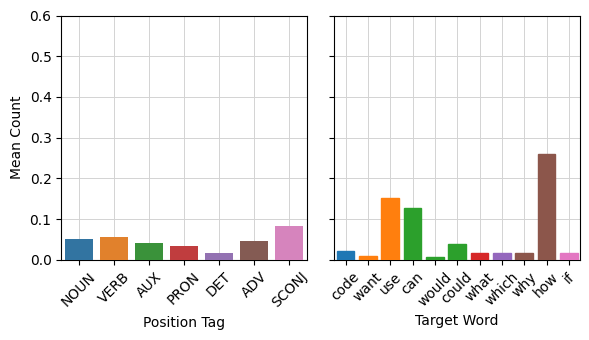

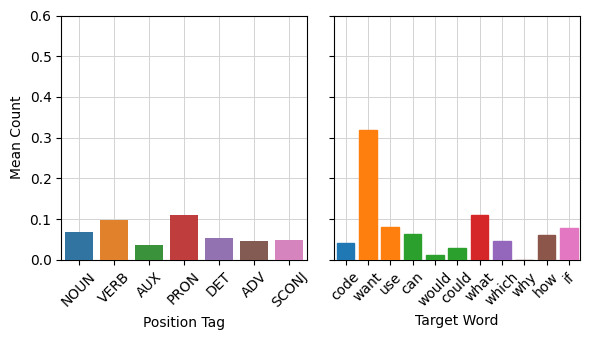

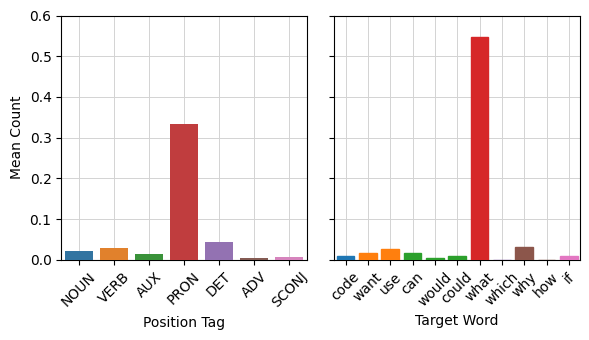

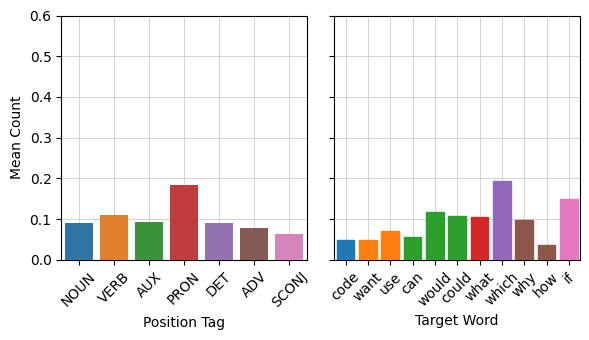

In [23]:
word_to_pos = {
    "why": "ADV",     # adverb (e.g., "Why is this happening?")
    "what": "PRON",   # pronoun (e.g., "What is this?")
    "which": "DET",   # determiner (e.g., "Which one do you want?")
    "if": "SCONJ",    # subordinating conjunction (e.g., "If this happens, then...")
    "how": "ADV",     # adverb (e.g., "How does this work?")
    "can": "AUX",     # auxiliary verb (e.g., "Can you help?")
    "would": "AUX",   # auxiliary verb (e.g., "Would you like help?")
    "could": "AUX",   # auxiliary verb (e.g., "Could this be possible?")
    "want": "VERB",   # verb (e.g., "I want to go.")
    "code": "NOUN",   # noun (e.g., "This is some code.") - Do you ever use it as a verb?
    "use": "VERB"     # verb (e.g., "I use this tool.") - Or do you need it as a noun too?
}

plot_features_and_targets(df_combined, feature_names, target_words, word_to_pos)

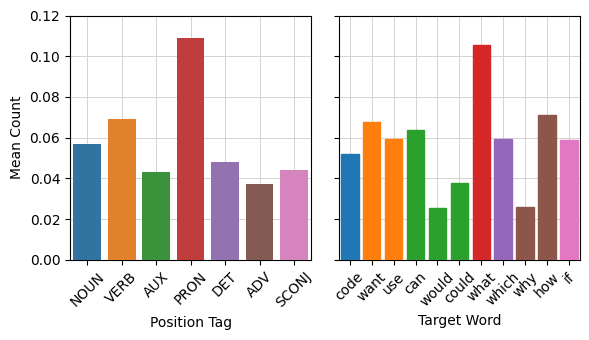

In [24]:
plot_overall_features_and_targets(df_combined, feature_names, target_words, word_to_pos)

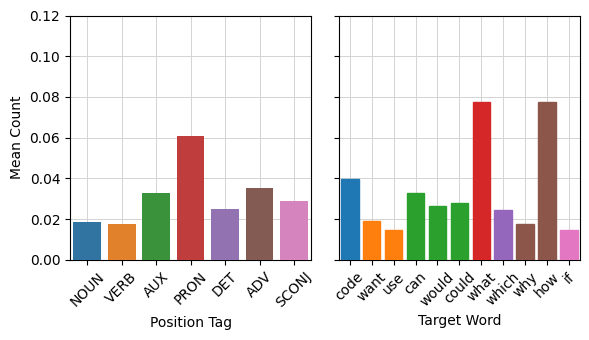

In [25]:
# repeat process for OPEN issue prompts
raw_tokens_open, tokenized_data_open, pos_data_open = get_tokenized(df_open)

# add raw tokens column
df_open['raw_tokens'] = raw_tokens_open

# get dataframe of normalized count of position tags
pos_df_open = transform_pos(pos_data_open, feature_names)

# get normalized count of target words
df_open = transform_word_count(df_open, target_words)

# combine with original dataframe
df_combined_open = pd.concat([df_open, pos_df_open], axis=1)

plot_overall_features_and_targets(df_combined_open, feature_names, target_words, word_to_pos)